In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [3]:
import pandas as pd
import deepmatcher as dm

In [14]:
train = pd.read_csv('sample_data/itunes-amazon/train.csv')
validation = pd.read_csv('sample_data/itunes-amazon/validation.csv')
test = pd.read_csv('sample_data/itunes-amazon/test.csv')

In [15]:
all_samples = pd.concat([train,validation,test])
positives = all_samples[all_samples.label==1]
positives.to_csv('sample_data/itunes-amazon/positives.csv',index=False)

In [5]:
train_positives = train[train['label']==1]
train_negatives = train[train['label']==0]

In [8]:
def get_price_distribution(df,left_prefix,right_prefix):
    prices = {}
    for idx,row in df.iterrows():
        current_prices = row[left_prefix+'Price']+ " "+ row[right_prefix+'Price']
        if current_prices in prices:
            prices[current_prices] += 1
        else:
            prices[current_prices] = 1
    return prices

In [10]:
price_negatives = get_price_distribution(train_negatives,'left_','right_')
price_negatives

{'$ 1.29 $ 1.29': 153,
 'Album Only $ 1.29': 20,
 '$ 1.29 $ 0.99': 18,
 '$ 1.99 $ 1.29': 25,
 '$ 1.29 $ 0.69': 3,
 '$ 0.99 $ 0.99': 11,
 '$ 1.99 $ 0.99': 3,
 '$ 0.99 $ 1.29': 11,
 '$ 0.99 $ 0.89': 2}

In [11]:
price_positives = get_price_distribution(train_positives,'left_','right_')
price_positives

{'$ 0.99 $ 0.99': 17,
 '$ 1.29 $ 1.29': 58,
 '$ 1.99 $ 1.29': 1,
 '$ 1.29 $ 0.89': 1}

In [12]:
train = pd.read_csv('../../Structured/itunes-amazon/merged_train.csv')
train_positives = train[train['label']==1]
train_negatives = train[train['label']==0]
price_negatives = get_price_distribution(train_negatives,'ltable_','rtable_')
price_negatives

{'$ 1.29 $ 1.29': 147,
 '$ 1.29 $ 0.99': 25,
 '$ 0.99 $ 0.89': 2,
 '$ 0.99 $ 0.99': 12,
 '$ 1.99 $ 0.99': 1,
 '$ 0.99 $ 1.29': 6,
 'Album Only $ 1.29': 20,
 '$ 1.29 $ 0.89': 2,
 '$ 1.99 $ 1.29': 25,
 '$ 1.29 $ 0.69': 3}

In [13]:
get_price_distribution(train_positives,'ltable_','rtable_')

{'$ 1.29 $ 1.29': 59,
 '$ 0.99 $ 0.99': 13,
 'Album Only $ 1.29': 1,
 'Album Only $ 0.99': 1,
 '$ 1.99 $ 1.29': 3,
 '$ 1.29 $ 0.89': 1}

### Evaluation changing prices

In [18]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/itunes_amazon_hybrid4.pth')

### Evaluate model on standard test set

In [19]:
test_pos = dm.data.process_unlabeled('sample_data/itunes-amazon/positives.csv',trained_model=hybrid_model,
                                ignore_columns = ['id','label'])


Reading and processing data from "sample_data/itunes-amazon/positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [20]:
standard_pred = hybrid_model.run_prediction(test_pos,output_attributes=True)

===>  PREDICT Epoch 9


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 9 || Run Time:    0.7 | Load Time:    0.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



In [21]:
standard_pred_neg = standard_pred[standard_pred['match_score']<=0.5]
standard_pred_neg.shape

(9, 18)

### Evaluate model on altered test set (on price)

In [50]:
test_positives = pd.read_csv('sample_data/itunes-amazon/positives.csv')

In [51]:
def alter_price(df,left_pr,right_pr):
    df['left_Price'] = left_pr
    df['right_Price'] = right_pr
    return df

In [52]:
test_pos_altered = alter_price(test_positives,'Album Only','$ 1.29')

In [53]:
test_pos_altered.to_csv('sample_data/itunes-amazon/test_positives_altered_price.csv',index=False)

In [54]:
test_pos_altered_price = dm.data.process_unlabeled('sample_data/itunes-amazon/test_positives_altered_price.csv'
                                                   ,trained_model=hybrid_model,ignore_columns=['id','label'])


Reading and processing data from "sample_data/itunes-amazon/test_positives_altered_price.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [55]:
altered_pred = hybrid_model.run_prediction(test_pos_altered_price,output_attributes=True)

===>  PREDICT Epoch 9


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 9 || Run Time:    0.5 | Load Time:    0.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



In [56]:
altered_pred_neg = altered_pred[altered_pred['match_score'] <=0.5]
altered_pred_neg.shape

(15, 18)

### Evaluate closer vectors on classifier space

In [ ]:
all_neg = pd.read_csv('sample_data/itunes-amazon/exp3/negative_samples.csv')

In [ ]:
closer_negatives = pd.read_csv('experiments-results/exp3/positives_closer_vectors_on_attribute.csv',sep=';')
closer_negatives.tail()

In [ ]:
join_df =pd.merge(left=all_neg,right=closer_negatives,left_on='id',right_on='Price')

In [ ]:
interested_columns = join_df.loc[:, ['id','left_Price','right_Price']]

In [ ]:
interested_columns.to_csv('experiments-results/exp6/closer_negatives_prices.csv',index=False)

## Create new training set with different price distribution

In [ ]:
for idx,row in train.iterrows():
    if row['label']==1:
        if idx % 2 ==0:
            train.at[idx,'left_Price'] = '$ 0.99'
            train.at[idx,'right_Price'] = '$ 0.99'
        else:
            train.at[idx,'left_Price'] = '$ 1.29'
            train.at[idx,'right_Price'] = '$ 1.29'
    else:
        if idx % 2 == 0:
            train.at[idx,'left_Price'] = 'Album Only'
            train.at[idx,'right_Price'] = '$ 1.29'
        else:
            train.at[idx,'left_Price'] = '$ 1.29'
            train.at[idx,'right_Price'] = '$ 1.29'

In [ ]:
for idx,row in validation.iterrows():
    if row['label']==1:
        if idx % 2 ==0:
            validation.at[idx,'left_Price'] = '$ 0.99'
            validation.at[idx,'right_Price'] = '$ 0.99'
        else:
            validation.at[idx,'left_Price'] = '$ 1.29'
            validation.at[idx,'right_Price'] = '$ 1.29'
    else:
        if idx % 2 == 0:
            validation.at[idx,'left_Price'] = 'Album Only'
            validation.at[idx,'right_Price'] = '$ 1.29'
        else:
            validation.at[idx,'left_Price'] = '$ 1.29'
            validation.at[idx,'right_Price'] = '$ 1.29'

In [ ]:
train.to_csv('sample_data/itunes-amazon/exp6/train_newprices.csv',index=False)

In [ ]:
validation.to_csv('sample_data/itunes-amazon/exp6/validation_newprices.csv',index=False)

In [ ]:
train,valid,test = dm.data.process('sample_data/itunes-amazon/exp6',train='train_newprices.csv',
                                   validation='validation_newprices.csv',test='test.csv',)

In [ ]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')

In [ ]:
hybrid_model.run_train(train,valid,best_save_path='models/hybrid_pricebias.pth',pos_neg_ratio=4,batch_size=16)

In [ ]:
hybrid_model.run_eval(test)

In [ ]:
test_pos_altered_price = dm.data.process_unlabeled('sample_data/itunes-amazon/exp6/test_positives_altered_price.csv'
                                                   ,trained_model=hybrid_model,ignore_columns=['id','label'])

In [ ]:
pred_new_model = hybrid_model.run_prediction(test_pos_altered_price,output_attributes=True)

In [ ]:
pred_neg_new_model = pred_new_model[pred_new_model['match_score']<=0.5]
pred_neg_new_model.shape

In [ ]:
test_pos = dm.data.process_unlabeled('sample_data/itunes-amazon/test_positives.csv',
                                    trained_model=hybrid_model,ignore_columns=['id','label'])

In [ ]:
pred_standardtest_newmodel = hybrid_model.run_prediction(test_pos,output_attributes=True)

In [ ]:
pred_standardtest_newmodel_negative = pred_standardtest_newmodel[pred_standardtest_newmodel['match_score']<=0.5]
pred_neg_new_model.shape

## Try to alter price in test set,

In [ ]:
test_pos = pd.read_csv('sample_data/itunes-amazon/test_positives.csv')

In [ ]:
alter_price(test_pos,'$ 0.99','$ 0.99')
test_pos.to_csv('sample_data/itunes-amazon/exp6/test_pos_099price.csv',index=False)

In [ ]:
test_pos.shape

In [ ]:
test_pos_099price = dm.data.process_unlabeled('sample_data/itunes-amazon/exp6/test_pos_099price.csv'
                                                   ,trained_model=hybrid_model,ignore_columns=['id','label'])

In [ ]:
preds = hybrid_model.run_prediction(test_pos_099price,output_attributes=True)
negative_preds = preds[preds['match_score']<=0.5]

In [ ]:
negative_preds.shape

## Create new dataset with balanced price

In [ ]:
def set_balanced_price(df):
    for idx,row in df.iterrows():
        if idx%2 ==0 :
            df.at[idx,'ltable_Price'] = '$ 0.99'
            df.at[idx,'rtable_Price'] ='$ 0.99'
        else:
            df.at[idx,'ltable_Price'] = '$ 1.29'
            df.at[idx,'rtable_Price'] ='$ 1.29'

In [ ]:
train = pd.read_csv('../../Structured/itunes-amazon/merged_train.csv')
validation = pd.read_csv('../../Structured/itunes-amazon/merged_valid.csv')
test = pd.read_csv('../../Structured/itunes-amazon/merged_test.csv')

In [ ]:
set_balanced_price(train)
set_balanced_price(test)
set_balanced_price(validation)

In [ ]:
train_positives = train[train['label']==1].copy()
train_negatives = train[train['label']==0].copy()

In [ ]:
get_price_distribution(train_positives)

In [ ]:
get_price_distribution(train_negatives)

In [ ]:
train.to_csv('../../Structured/itunes-amazon/exp6/train_balanced.csv',index=False)
validation.to_csv('../../Structured/itunes-amazon/exp6/validation_balanced.csv',index=False)
test.to_csv('../../Structured/itunes-amazon/exp6/test_balanced.csv',index=False)

In [ ]:
train_negatives = train[train['label']==0]
validation_negatives = validation[validation['label']==0]
test_negatives = test[test['label']==0]

In [ ]:
train_positives = train[train['label']==1]
validation_positives = validation[validation['label']==1]
test_positives = test[test['label']==1]

In [ ]:
negatives_df = train_negatives.append(validation_negatives,ignore_index=True)
negatives_df = negatives_df.append(test_negatives,ignore_index=True)
positives_df = train_positives.append(validation_positives,ignore_index=True)
positives_df = positives_df.append(test_positives,ignore_index=True)

In [ ]:
negatives_df.head()

In [ ]:
negatives_df.to_csv('../../Structured/itunes-amazon/exp6/negatives_balanced.csv',index=False)
positives_df.to_csv('../../Structured/itunes-amazon/exp6/positives_balanced.csv',index=False)

In [ ]:
get_price_distribution(negatives_df)

In [ ]:
get_price_distribution(positives_df)

### Train model with balanced dataset

In [4]:
train,validation,test = dm.data.process('../../Structured/itunes-amazon/exp6',train='train_balanced.csv',validation='validation_balanced.csv',
                                       test='test_balanced.csv',left_prefix='ltable_',right_prefix='rtable_')

In [4]:
model = dm.MatchingModel(attr_summarizer='hybrid')

In [5]:
model.load_state('../../models/itunesamazon_hybrid_balanced_data.pth')
model.cuda()

MatchingModel(
  (attr_summarizers): ModuleMap(
    (Song_Name): Hybrid(
      (word_contextualizer): RNN(
        (rnn_groups): ModuleList(
          (0): GRU(300, 150, batch_first=True, bidirectional=True)
        )
        (dropouts): ModuleList(
          (0): Dropout(p=0)
        )
        (bypass_networks): ModuleList(
          (0): None
        )
        (input_dropout): NoMeta(
          (module): Dropout(p=0)
        )
      )
      (word_comparator): Attention(
        (alignment_networks): ModuleList(
          (0): AlignmentNetwork(
            (transform): Transform(
              (transforms): ModuleList(
                (0): Linear(in_features=300, out_features=300, bias=True)
                (1): Linear(in_features=300, out_features=300, bias=True)
              )
              (bypass_networks): ModuleList(
                (0): Bypass(
                  (highway_gate): Linear(in_features=300, out_features=300, bias=True)
                )
                (1): Bypass(


In [ ]:
model.run_train(train,validation,best_save_path='../../models/itunesamazon_hybrid_balanced_data.pth',epochs=20,batch_size=16,
               pos_neg_ratio=4)

In [ ]:
model.run_eval(test)

### Calculate Ri with new model

In [12]:
from utilities_functions.intermediate_layer_extraction import return_layer_input
from utilities_functions.ri_calculator import find_smallest_variation_to_change
import torch

In [7]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/itunes-amazon/exp6'
                                                                         ,'negatives_balanced',32,model,
                                                                        model.classifier,dataset2_name='validation_balanced.csv')

In [8]:
negative_classifier_inputs = list(map(lambda x: x[0],neg_classifier_inputs))

In [9]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/itunes-amazon/exp6'
                                                                         ,'positives_balanced',32,model,
                                                                        model.classifier,dataset2_name='validation_balanced.csv')

In [10]:
positive_classifier_inputs = list(map(lambda x: x[0],pos_classifier_inputs))

In [15]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

In [17]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_matrix = []
for batch in negative_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(model.classifier,
                                                                                    classifier_length=1200,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=1),attributes))
        negatives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13
Processing sample number 14
Processing sample number 15
Processing sample number 16
Processing sample number 17
Processing sample number 18
Processing sample number 19
Processing sample number 20
Processing sample number 21
Processing sample number 22
Processing sample number 23
Processing sample number 24
Processing sample number 25
Processing sample number 26
Processing sample number 27
Processing sample number 28
Processing sample number 29
Processing sample number 30
Processing sample number 31
Processing sample number 32
Processing sample number 33
Processing sample number 34
Processing sample number 35
Pr

Processing sample number 287
Processing sample number 288
Processing sample number 289
Processing sample number 290
Processing sample number 291
Processing sample number 292
Processing sample number 293
Processing sample number 294
Processing sample number 295
Processing sample number 296
Processing sample number 297
Processing sample number 298
Processing sample number 299
Processing sample number 300
Processing sample number 301
Processing sample number 302
Processing sample number 303
Processing sample number 304
Processing sample number 305
Processing sample number 306
Processing sample number 307
Processing sample number 308
Processing sample number 309
Processing sample number 310
Processing sample number 311
Processing sample number 312
Processing sample number 313
Processing sample number 314
Processing sample number 315
Processing sample number 316
Processing sample number 317
Processing sample number 318
Processing sample number 319
Processing sample number 320
Processing sam

In [18]:
ri_norms_negative_samples = []
for ri_list in negatives_ri_matrix:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

In [22]:
import pandas as pd
neg_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)

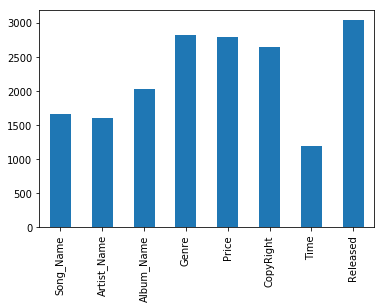

In [26]:
ri_sums_neg = neg_variation_df.sum(numeric_only=True)
ri_sums_neg.plot.bar()

In [20]:
variation_df.to_csv('experiments-results/exp6/negatives_ri.csv',index=False)

In [29]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri_matrix = []
for batch in positive_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(model.classifier,
                                                                                    classifier_length=1200,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=0),attributes))
        positives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13
Processing sample number 14
Processing sample number 15
Processing sample number 16
Processing sample number 17
Processing sample number 18
Processing sample number 19
Processing sample number 20
Processing sample number 21
Processing sample number 22
Processing sample number 23
Processing sample number 24
Processing sample number 25
Processing sample number 26
Processing sample number 27
Processing sample number 28
Processing sample number 29
Processing sample number 30
Processing sample number 31
Processing sample number 32
Processing sample number 33
Processing sample number 34
Processing sample number 35
Pr

In [31]:
ri_norms_positives = []
for ri_list in positives_ri_matrix:
    ri_norms_positives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

In [33]:
import pandas as pd
variation_df = pd.DataFrame(data= ri_norms_positives,columns=attributes)
variation_df.head(10)

,Song_Name,Artist_Name,Album_Name,Genre,Price,CopyRight,Time,Released
0,3.878629,3.446531,5.157091,10.629272,12.656943,6.956674,2.607377,11.481276
1,6.811184,4.795303,9.300212,14.824529,18.101393,12.978064,3.751681,16.480644
2,4.204144,3.762440,5.490333,8.265757,9.435639,7.328086,2.867665,8.838511
3,6.205582,4.330556,8.356042,13.033231,15.185880,11.404290,4.098040,14.175168
4,6.099616,5.097409,8.162665,12.738205,15.116776,11.287558,4.001896,16.849686
5,7.470128,6.163949,10.041266,15.763659,17.478144,13.974194,4.894129,17.005236
6,5.253518,4.588130,6.998690,10.715034,12.334240,9.427354,3.531579,11.492807
7,4.161211,3.743714,5.477698,8.265800,9.608536,7.274934,2.836657,8.854489
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,3.967896,3.582455,5.296558,8.058961,9.674148,7.062239,2.696892,8.630033


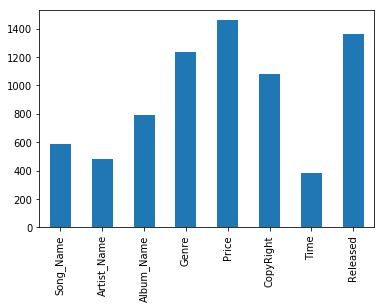

In [34]:
ri_sums_pos= variation_df.sum(numeric_only=True)
ri_sums_pos.plot.bar()

In [ ]:
variation_df.to_csv('experiments-results/exp6/positives_ri.csv',index=False)